In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings

from sklearn.model_selection import train_test_split   # 数据划分

from sklearn.pipeline import Pipeline # 管道
from sklearn.preprocessing import MinMaxScaler  # 数据预处理 - 归一
from sklearn.feature_selection import SelectKBest   # 特征选择
from sklearn.feature_selection import chi2   # 卡方统计量
from sklearn.decomposition import PCA   # 降维 - 主成分分析
from sklearn.tree import DecisionTreeClassifier   # 分类树

from sklearn.model_selection import GridSearchCV  # 网格搜索交叉验证，用于选择最优的参数

In [2]:
## 设置属性防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
names = ['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度','花型']
iris_class = 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'

##### 1、读取数据 

In [4]:
path = './datas/iris.data'  
data = pd.read_csv(path, header=None,names = names)
data.head()

,花萼长度,花萼宽度,花瓣长度,花瓣宽度,花型
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


##### 2、数据处理 + 数据分割
—— data[ column ].value_counts()   查看某列的数据类型及数量，在本题中输出 Iris-virginica=50; Iris-versicolor=50; Iris-setosa=50   ★

—— pd.Categorical(y).codes   把文本数据进行编码, 把y不同类型的值转换成数字编码类型，从0开始，0,1,2...。通常用于Y的数字标签化   ★

    常配合使用

In [5]:
x=data[names[:-1]]
y=data[names[-1]]
y=pd.Categorical(y).codes   # 把类型值的y转换成数字编码类型 0,1,2

print("总样本数目：%d;特征属性数目:%d" % x.shape)

总样本数目：150;特征属性数目:4


—— .astype(np.int) 转int类型 

In [6]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, train_size=0.8, random_state=14)

x_train, x_test, y_train, y_test = x_train1, x_test1, y_train1, y_test1
print ("训练数据集样本数目：%d, 测试数据集样本数目：%d" % (x_train.shape[0], x_test.shape[0]))

x_train.head()

训练数据集样本数目：120, 测试数据集样本数目：30


,花萼长度,花萼宽度,花瓣长度,花瓣宽度
39,5.1,3.4,1.5,0.2
93,5.0,2.3,3.3,1.0
73,6.1,2.8,4.7,1.2
14,5.8,4.0,1.2,0.2
69,5.6,2.5,3.9,1.1


##### 3、数据预处理 - 标准化训练 
数据处理后，由DataFrame转为了数组array

—— StandardScaler (基于特征矩阵的列，将属性值转换至服从正态分布)
    
    将样本的特征值转换到同一量纲下
    常用于基于正态分布的算法，比如回归

—— MinMaxScaler 归一化，将属性缩放到一个指定的最大和最小值（通常是1-0）之间

    提升模型收敛速度，提升模型精度
    对于方差非常小的属性可以增强其稳定性
    维持稀疏矩阵中为0的条目
    常见用于神经网络
    
    -》.min 特征属性的调整最小值
    -》.scale 特征属性的缩放数据值

—— Normalizer （基于矩阵的行，将样本向量转换为单位向量）
    
    其目的在于样本向量在点乘运算或其他核函数计算相似性时，拥有统一的标准
    常见用于文本分类和聚类，logistic回归中也会使用，可有效防止过拟合
    
回归模型经常用StandardScaler，分类模型常用MinMaxScaler  ★

In [7]:
ss = MinMaxScaler ()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

print ("MinMaxScaler标准化后，各特征属性的最小值:",ss.min_)
print ("MinMaxScaler标准化时，各特征属性的缩放数据值:",ss.scale_)

type(x_train)
x_train[:5]

MinMaxScaler标准化后，各特征属性的最小值: [-1.19444444 -0.83333333 -0.18965517 -0.04166667]
MinMaxScaler标准化时，各特征属性的缩放数据值: [ 0.27777778  0.41666667  0.17241379  0.41666667]


array([[ 0.22222222,  0.58333333,  0.06896552,  0.04166667],
       [ 0.19444444,  0.125     ,  0.37931034,  0.375     ],
       [ 0.5       ,  0.33333333,  0.62068966,  0.45833333],
       [ 0.41666667,  0.83333333,  0.01724138,  0.04166667],
       [ 0.36111111,  0.20833333,  0.48275862,  0.41666667]])

##### 3.1、特征选择
—— SelectKBest（卡方系数,k）：从已有的特征中选择出影响目标值最大的k个特征属性:k默认为10

    ①、分类：F统计量、卡方系数，互信息mutual_info_classif
    ②、连续：皮尔逊相关系数 F统计量 互信息mutual_info_classif

—— get_support(indices=True) ：获取特征筛选结果，返回列编号

    也可以通过.scores_方法获取各个特征的分数

In [8]:
ch2 = SelectKBest(chi2,k=3)   # 从原始的特征属性(共4个)中选出3个
x_train = ch2.fit_transform(x_train, y_train)   # 在特征选择中，要引入Y，拟合X和Y的数据，获取X特征属性影响力
x_test = ch2.transform(x_test)

select_name_index = ch2.get_support(indices=True)
print ("对类别判断影响最大的三个特征属性分布是:",select_name_index)

x_train[:5]

对类别判断影响最大的三个特征属性分布是: [0 2 3]


array([[ 0.22222222,  0.06896552,  0.04166667],
       [ 0.19444444,  0.37931034,  0.375     ],
       [ 0.5       ,  0.62068966,  0.45833333],
       [ 0.41666667,  0.01724138,  0.04166667],
       [ 0.36111111,  0.48275862,  0.41666667]])

##### 3.2、降维 
对于数据而言，如果特征属性过多，构建过程会比较复杂，此时考虑将多维（高维）数据映射到低维
#常用的方法：

—— PCA(n_components)：主成分分析（无监督），降低到 n_components 维度

    -》.explained_variance_ratio_ ：表示降维后的 各主成分方差值 占 总方差值 的比例，这个比例越大，则该成分越重要。即单变量方差贡献率
—— LDA：线性判别分析（有监督）类内方差最小，人脸识别，通常先做一次PCA

In [9]:
pca = PCA(n_components=2)   # 在画图时用2维，平时用默认值
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

print(pca.explained_variance_ratio_)
x_train[:5]

[ 0.93623786  0.05173032]


array([[-0.64107493, -0.05592058],
       [-0.2432057 ,  0.16017604],
       [ 0.0948966 , -0.04180635],
       [-0.5888552 , -0.22744693],
       [-0.07891242,  0.04585431]])

##### 4、决策树模型构建 + 模型训练 + 预测 + 评估
—— DecisionTreeClassifier() 分类决策树

    criterion='gini' ：决策树分割属性标准。默认为gini系数，也就是CART；可选entropy，表示使用信息熵
    splitter='best' ：给定选择划分属性时，采用什么方式，默认为best，表示选择最优的方式划分；可选random，表示随机
    max_depth=None ：树的最大允许深度，默认不限制
    min_samples_split=2 ：阈值，节点样本数小于等于该值时，停止树的构建
    
—— .classes_ 获取模型标签值（二进制值）

In [10]:
model = DecisionTreeClassifier(criterion='entropy',random_state=0)
model.fit(x_train, y_train)   # 模型训练
y_predict = model.predict(x_test)   # 模型预测

print ("Score：", model.score(x_test, y_test))   # R^2 准确率 ；3.1和3.2将准确率提高了
print ("Classes:", model.classes_)

Score： 0.966666666667
Classes: [0 1 2]


In [11]:
# 分类算法的.score可以看成下面的结果
result = (y_test == y_predict)   # 验证准确数量
print ("准确率:%.2f%%" % (np.mean(result) * 100))   # 准确率

准确率:96.67%


##### 5、画图
一般不会用flat_x = np.stack((grid_x.ravel(), grid_y.ravel()), axis=1)  待定

In [19]:
# 1、通过取值范围获取测试点 - 由于之前做了区间缩放预处理，所以x_train和x_test的范围被压缩了

x1_min = np.min((x_train[:,0].min(), x_test[:,0].min()))   # 第一个属性组
x1_max = np.max((x_train[:,0].max(), x_test[:,0].max()))
x2_min = np.min((x_train[:,1].min(), x_test[:,1].min()))   # 第二个属性组
x2_max = np.max((x_train[:,1].max(), x_test[:,1].max()))

# x1_min, x2_min = x_train.min()   # DataFrame数据默认按列处理  用上面的方法保证了图形的完整性，但有时也会用下面方法来简单处理
# x1_max, x2_max = x_train.max()

t1 = np.linspace(x1_min, x1_max, 100)   # x坐标点 (100,)  在横纵坐标各取100点
t2 = np.linspace(x2_min, x2_max, 100)   # y坐标点 (100,)

grid_x, grid_y = np.meshgrid(t1, t2)  # 2、生成网格采样点 （100*100），覆盖了整个绘图区域
flat_x = np.dstack((grid_x.ravel(), grid_y.ravel())).reshape(-1,2)   # 3、对应元素重组，得到栅格点阵坐标。注意删去最外层无用的[]

flat_y = model.predict(flat_x)  # 模型预测 - 用训练好的模型对栅格点进行预测，以获得每个点的标签类型
grid_label = flat_y.reshape(grid_x.shape)  # 使标签值匹配grid_x / grid_y网格采样点，保持形状一致

—— mpl.colors.ListedColormap() 设置颜色类型。注意这里是mpl  ★★★

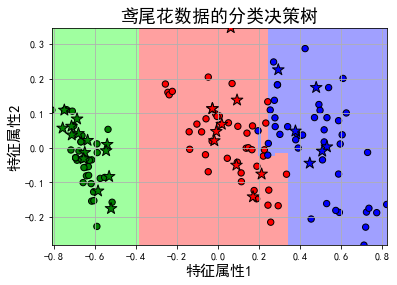

In [318]:
plt.figure(facecolor='w')

plt_light = mpl.colors.ListedColormap(['#A0FFA0', '#FFA0A0', '#A0A0FF'])   # 设置浅色色系，以映射y_show
plt_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])   # 深色，以映射y_train

plt.pcolormesh(grid_x, grid_y, grid_label, cmap=plt_light)   # 类别区域图，分类底色
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, edgecolors='k', s=40, cmap=plt_dark)  # 训练集样本类别情况
plt.scatter(x_test[:,0], x_test[:,1], c=y_predict, edgecolors='k', s=150, zorder=10, cmap=plt_dark, marker='*')  # 测试集样本类别情况

plt.xlabel('特征属性1', fontsize=15)
plt.ylabel('特征属性2', fontsize=15)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.grid(True)
plt.title('鸢尾花数据的分类决策树', fontsize=18)
plt.show()

# 在多模型和参数中找最优方案

##### 1、管道准备 + 参数字典 + 数据划分（已分好）

In [249]:
pipe = Pipeline([
            ('mms', MinMaxScaler()),
            ('skb', SelectKBest(chi2)),
            ('pca', PCA()),
            ('decision', DecisionTreeClassifier(random_state=0))
        ])

parameters = {
    "skb__k": [1,2,3,4],   # 卡方系数
    "pca__n_components": [0.5,0.99],   # —— n_components 设置为浮点数（小数）时，表示主成分方差所占最小比例的阈值
    
    "decision__criterion": ["gini", "entropy"],   # 决策树使用的方法
    "decision__max_depth": [1,2,3,4,5,6,7,8,9,10]   # 最大深度
}

x_train2, x_test2, y_train2, y_test2 = x_train1, x_test1, y_train1, y_test1

##### 2、(数据预处理 + 模型构建 )+ 训练 + 预测 + 评估

In [250]:
gscv = GridSearchCV(pipe, param_grid=parameters,cv=3)   # 通过网格交叉验证，寻找最优参数列表
gscv.fit(x_train2, y_train2)   #模型训练
y_predict2 = gscv.predict(x_test2)  # 模型预测

print("最优参数列表:", gscv.best_params_)
print("score值：",gscv.best_score_)

最优参数列表: {'decision__criterion': 'gini', 'decision__max_depth': 4, 'pca__n_components': 0.99, 'skb__k': 3}
score值： 0.95


C:\4_IT\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 对交叉结果进行自行验证 应用最优参数看效果

In [251]:
mms_best = MinMaxScaler()
skb_best = SelectKBest(chi2, k=3)
pca_best = PCA(n_components=0.99)
decision3 = DecisionTreeClassifier(criterion='gini', max_depth=4)

In [252]:
x_train3, x_test3, y_train3, y_test3 = x_train1, x_test1, y_train1, y_test1

x_train3 = pca_best.fit_transform(skb_best.fit_transform(mms_best.fit_transform(x_train3), y_train3))
x_test3 = pca_best.transform(skb_best.transform(mms_best.transform(x_test3)))

print("正确率:", decision3.score(x_test3, y_test3))

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

### GridSearchCV 模型保存和加载

In [ ]:
from sklearn.externals import joblib

best_gscv_model = gscv.best_estimator_
joblib.dump(best_gscv_model, "gscv.model")

In [ ]:
# 加载已经预处理了的CV模型
best_gscv_model_new = joblib.load("gscv.model")

# 决策树可视化

##### 方式一：输出形成dot文件，然后使用graphviz的dot命令将dot文件转换为pdf

In [ ]:
from sklearn import tree
with open('iris.dot', 'w') as f:
    f = tree.export_graphviz(model, out_file=f)
# 命令行执行dot命令： dot -Tpdf iris.dot -o iris.pdf

##### 方式二：直接使用pydotplus插件生成pdf文件

In [ ]:
from sklearn import tree
import pydotplus 
dot_data = tree.export_graphviz(model, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
# graph.write_pdf("iris2.pdf") 
graph.write_png("0.png")

##### 方式三：直接生成图片

In [ ]:
from sklearn import tree
from IPython.display import Image
import pydotplus

dot_data = tree.export_graphviz(model, out_file=None, 
#                          feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'],  
                         feature_names=[u'特征属性1', u'特征属性2'],  
                         class_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 